<a href="https://colab.research.google.com/github/mhmdreza-gp/python-fmask/blob/master/Welcome_to_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 14.5 MB/s eta 0:00:00


In [4]:
!pip install rasterio joblib matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 31.4 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# وارد کردن کتابخانه‌های لازم
import numpy as np
import rasterio
from rasterio.plot import show
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import os
from joblib import dump, load

# مسیر فایل‌های داده
data_path = '/content/drive/MyDrive/test.tif'
output_path = '/content/drive/MyDrive/classified_image.tif'
model_path = '/content/drive/MyDrive/rf_model.joblib'


Validation Accuracy: 0.9703960015378701
Model saved to /content/drive/MyDrive/rf_model.joblib
Classified image saved to /content/drive/MyDrive/classified_image.tif


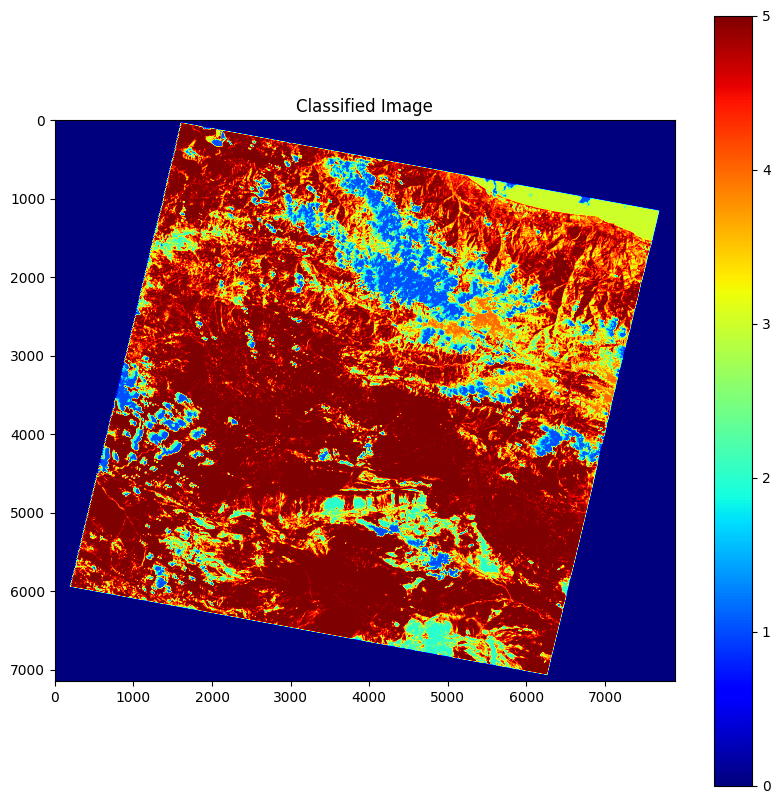

In [6]:
# خواندن تصویر و آماده‌سازی داده‌ها
with rasterio.open(data_path) as src:
    img = src.read()
    profile = src.profile

# لایه‌های آموزشی و باندها
training_layer = img[0]  # لایه داده‌های آموزشی
bands = img[1:]          # باندهای 1 تا 7

# ماسک برای حذف پیکسل‌هایی که داده آموزشی ندارند یا باند صفر دارند
mask = (training_layer > 0) & (bands.sum(axis=0) > 0)

# داده‌ها را به شکل برداری تبدیل کنید
X = bands[:, mask].T  # ورودی‌ها
y = training_layer[mask]  # برچسب‌ها

# تقسیم داده‌ها به مجموعه آموزش و اعتبارسنجی
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# مدل رندوم فارست
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# پیش‌بینی برای داده‌های اعتبارسنجی
y_pred = rf.predict(X_val)

# محاسبه دقت مدل
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

# ذخیره مدل آموزش‌دیده
dump(rf, model_path)
print(f"Model saved to {model_path}")

# پیش‌بینی کل تصویر
all_pixels = bands.reshape((bands.shape[0], -1)).T
all_mask = bands.sum(axis=0).ravel() > 0
all_predicted = np.zeros(all_pixels.shape[0], dtype=np.uint8)
all_predicted[all_mask] = rf.predict(all_pixels[all_mask])

# بازگردانی به ابعاد اصلی تصویر
classified_img = all_predicted.reshape((bands.shape[1], bands.shape[2]))

# بررسی و حذف فایل خروجی قبلی در صورت وجود
if os.path.exists(output_path):
    os.remove(output_path)
    print(f"Existing file {output_path} removed.")

# ذخیره تصویر طبقه‌بندی شده
profile.update(dtype=rasterio.uint8, count=1)
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(classified_img, 1)

print(f"Classified image saved to {output_path}")

# نمایش تصویر طبقه‌بندی شده
plt.figure(figsize=(10, 10))
plt.imshow(classified_img, cmap='jet')
plt.title("Classified Image")
plt.colorbar()
plt.show()


Model loaded from /content/drive/MyDrive/rf_model.joblib
Number of bands: 7
Classified image saved to /content/drive/MyDrive/classified_new_image.tif


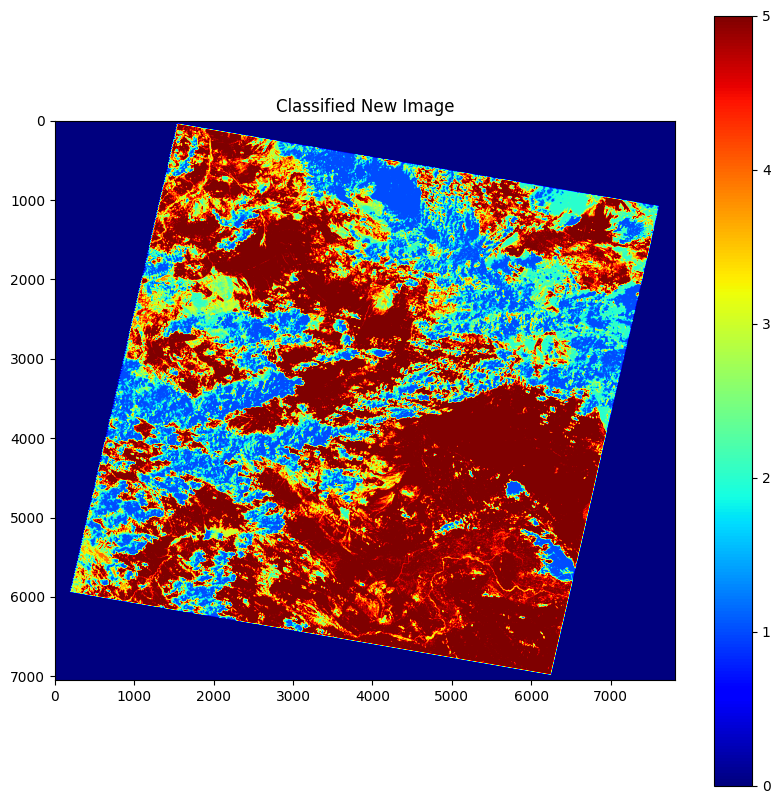

In [7]:
# وارد کردن کتابخانه‌های لازم
import numpy as np
import rasterio
from rasterio.plot import show
from joblib import load
import matplotlib.pyplot as plt
import os

# مسیر فایل‌ها
new_image_path = '/content/drive/MyDrive/stacked11.tif'
model_path = '/content/drive/MyDrive/rf_model.joblib'
output_path = '/content/drive/MyDrive/classified_new_image.tif'

# بارگذاری مدل ذخیره شده
rf = load(model_path)
print("Model loaded from", model_path)

# خواندن تصویر جدید و پردازش داده‌ها
with rasterio.open(new_image_path) as src:
    img = src.read()
    profile = src.profile

# بارگذاری باندهای 1 تا 7
bands = img[0:7]
print("Number of bands:", bands.shape[0])

# حذف پیکسل‌هایی که مقدار صفر دارند
all_pixels = bands.reshape((bands.shape[0], -1)).T
all_mask = bands.sum(axis=0).ravel() > 0

# ایجاد آرایه‌ای برای ذخیره نتایج طبقه‌بندی
all_predicted = np.zeros(all_pixels.shape[0], dtype=np.uint8)

# پیش‌بینی پیکسل‌ها با استفاده از مدل ذخیره‌شده
all_predicted[all_mask] = rf.predict(all_pixels[all_mask])

# بازگردانی به ابعاد اصلی تصویر
classified_img = all_predicted.reshape((bands.shape[1], bands.shape[2]))

# بررسی و حذف فایل خروجی قبلی در صورت وجود
if os.path.exists(output_path):
    os.remove(output_path)
    print(f"Existing file {output_path} removed.")

# ذخیره تصویر طبقه‌بندی شده جدید
profile.update(dtype=rasterio.uint8, count=1)
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(classified_img, 1)

print(f"Classified image saved to {output_path}")

# نمایش تصویر طبقه‌بندی شده
plt.figure(figsize=(10, 10))
plt.imshow(classified_img, cmap='jet')
plt.title("Classified New Image")
plt.colorbar()
plt.show()
